In [ ]:
# Miscellaneous testing for Eric - others please do not edit - git doesn't play nice with jupyter notebooks

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import optuna

In [ ]:

path = "../active/outputs/test/move_data.csv"
results = pd.read_csv(path,index_col=0)
results["cumulative_reward"] = results.reward.cumsum()
fig = plt.figure(constrained_layout=False,figsize=(13,6))
ax=sns.lineplot(data=results,x=results.index, y = "cumulative_reward")
ax2 = plt.twinx()
sns.lineplot(data=results.epsilon, color="b", ax=ax2)

path2 = "../active/outputs/test/episode_data.csv"
episode_results = pd.read_csv(path2,index_col=0)
fig2 = plt.figure(constrained_layout=False,figsize=(13,6))
ax3 = sns.lineplot(data=episode_results,x=episode_results.index, y = episode_results.rolling(10).mean().reward)

path3 = "../active/outputs/test/loss_data.csv"
loss_results = pd.read_csv(path3,index_col=0)
fig3 = plt.figure(constrained_layout=False,figsize=(13,6))
ax4 = sns.lineplot(data=loss_results,x=loss_results.index, y = loss_results.loss)

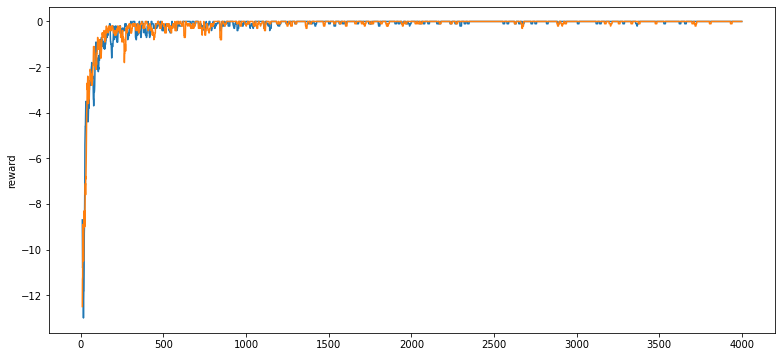

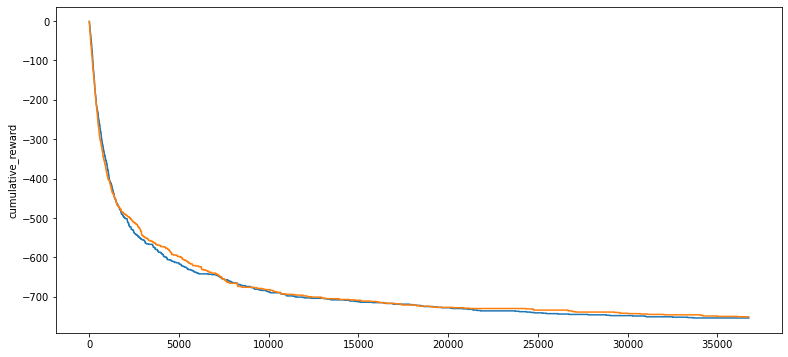

In [22]:
# Multi run results
path = "../active/outputs/test/other_clockwiseTwoFree"
#path = "../active/outputs/test/other_clockwiseTwoFreeAlt"
#path = "../active/outputs/test/other_clockwiseZeroStart"
#path = "../active/outputs/test/other_1_1_shape_4m"
#path = "../active/outputs/test/other_1_2_shape_4m"

fig = plt.figure(constrained_layout=False,figsize=(13,6))
for i in np.arange(0,2):
    run_path = path + "/"+str(i)+"/episode_data.csv"
    episode_results = pd.read_csv(run_path,index_col=0)
    sns.lineplot(data=episode_results,x=episode_results.index, y = episode_results.rolling(10).mean().reward)
fig2= plt.figure(constrained_layout=False,figsize=(13,6))
for i in np.arange(0,2):
    run_path = path + "/"+str(i)+"/move_data.csv"
    results = pd.read_csv(run_path,index_col=0)
    results["cumulative_reward"] = results.reward.cumsum()
    sns.lineplot(data=results,x=results.index, y = "cumulative_reward")

In [2]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

In [6]:
study_name = "naive_n8_clockwiseTwoFree_8reps"
storage_name = "sqlite:///../active/outputs/tuning/{}.db".format(study_name)
study = optuna.study.load_study(study_name=study_name,storage=storage_name)

In [7]:
study.best_params

{'LR': 0.0007047042471752638,
 'clamp': 1,
 'decay': 109,
 'gamma': 0.10702665557601941,
 'grad_batch': 206,
 'n_layers': 2,
 'optimizer': 'ADAM',
 'size': 422}

In [8]:
plot_optimization_history(study)

In [ ]:
plot_parallel_coordinate(study)

In [ ]:
plot_contour(study)

In [ ]:
#import lightgbm as lgb
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split


In [ ]:
plot_param_importances(study)

In [ ]:
#print(np.ravel_multi_index((o_row,o_col,b_index),(6,6,4)))
print(np.unravel_index(72, (6,6,4)))